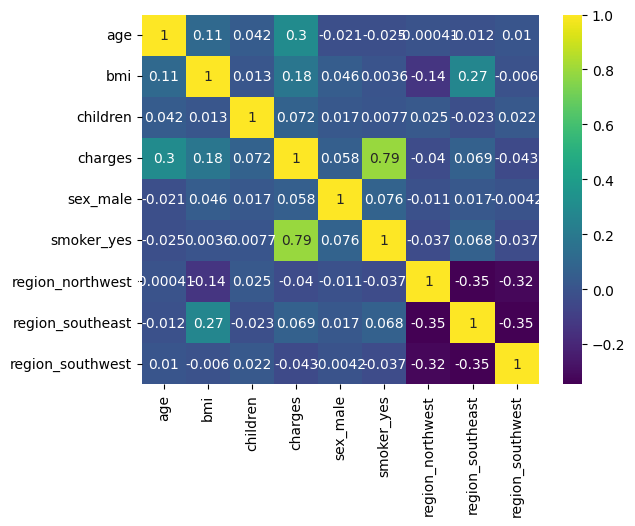

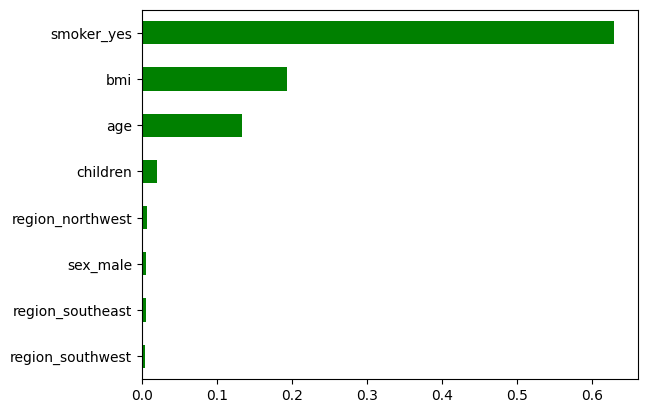

Baseline R²: 0.7315207235991059
Improved R²: 0.7767243208226585
Best R²: 0.8252166586865464


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load data
df = pd.read_csv('/content/insurance.csv')

# Standardizing the text
df['sex'] = df['sex'].str.lower().str.strip()
df['smoker'] = df['smoker'].str.lower().str.strip()
df['region'] = df['region'].str.lower().str.strip()

# Replacing common typos
df['sex'] = df['sex'].replace({'mal': 'male', 'femal': 'female'})

# Impute missing values
for col in df.select_dtypes(include='object'):
    df[col] = df[col].fillna(df[col].mode()[0])
for col in df.select_dtypes(exclude='object'):
    df[col] = df[col].fillna(df[col].mean())

# Remove outliers using IQR
num_cols = ['age', 'bmi', 'children', 'charges']
for col in num_cols:
    quartile_1 = df[col].quantile(0.25)
    quartile_3 = df[col].quantile(0.75)
    inter_quartile_range = quartile_3 - quartile_1
    lower = quartile_1 - 2.0 * inter_quartile_range
    upper = quartile_3 + 2.0 * inter_quartile_range
    df[col] = np.clip(df[col], lower, upper)

# EDA and Feature Selection
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
sns.heatmap(df_encoded.corr(), annot=True, cmap='viridis')
plt.show()

X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

rf = RandomForestRegressor(n_estimators=250, random_state=72)
rf.fit(X, y)
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh', color='green')
plt.show()

# Preprocessing pipeline
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)],
    remainder='passthrough')

# training a regression model
# Baseline Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=72)
baseline_model = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', LinearRegression())])
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)
print("Baseline R²:", r2_score(y_test, y_pred_base))

# Improved Model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', XGBRegressor(n_estimators=1200, learning_rate=0.07, max_depth=5, random_state=72))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Improved R²:", r2_score(y_test, y_pred))

# Hyperparameter tuning
param_grid = {'regressor__n_estimators': [300, 600],
              'regressor__max_depth': [4, 8]}
grid = GridSearchCV(model, param_grid, cv=4, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best R²:", grid.best_score_)